# Cloud Diffusion: Inference
With the models trained, we can now use the reverse diffusion procedure to create images! Our goal here is to compare the white noise diffusion model to our Cloud Diffusion model. We will use unconditional image generation where images are seeded with an initial pure-noise tensor and the model predicts the noise over many (~1000) time steps and removes it to gradually form an image. Unconditional means that the inference procedure is not guided by anything else like a text or image prompt. The model guesses that there the initial noise tensor has some signal buried in the noise and iteratively removes the noise by guessing the noise tensor at each time step. While this will not produce the highest quality images, it will allow for a raw comparison between the models.

This notebook is the fourth in a series:
1. [Cloud Diffusion Part 1: Scale Invariance](./CD_Scale_Invariance.ipynb)
2. [Cloud Diffusion Part 2: Overview](./CD_Overview.ipynb)
3. [Cloud Diffusion Part 3: Training](./CD_Training.ipynb)
4. [Cloud Diffusion Part 4: Inference (this notebook)](./CD_Inference.ipynb)

## Loading the Saved Models

In [1]:
# Import packages
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time
import torchvision.utils
import importlib
import data
import helpers
import unet
import cloud_diffusion as cd
import copy
import IPython.display
from IPython.display import Video

In [3]:
# Uncomment and run these when making changes to .py files that require reloading modules
# Can also restart kernel, but this allows for reloading without running everything again
importlib.reload(data)
importlib.reload(helpers)
importlib.reload(unet)
importlib.reload(cd)

<module 'cloud_diffusion' from '/Users/ac.randono/Python Projects/AI Experiments/Scale Invariance/cloud_diffusion.py'>

In [4]:
white_model = data.load_checkpoint("white_model_1")

Model Parameters = 3359539


In [5]:
cloud_model = data.load_checkpoint("cloud_model_1")

Model Parameters = 3359539


## Generating Images
To generate images we reverse the diffusion process, using the trained model to predict the noise at each timestep, removing the noise, and iterating. We can skip timesteps to generate images quicker, but the highest quality images come from a reverse diffusion process through all of the timesteps used in training (~1000). 

We start with a reverse diffusion process that predicts the total noise as opposed to the incremental noise added each time step, and removes only the small incremental predicted noise as dictated by the time schedule. The predicted noise is then fed back to corrupt the predicted image, but with an amplitude one step lower. Note that in this reverse diffusion pass, the only pure noise tensor that is injected into the systems is the initial noise tensor. 

Next we employ a stochastic approach where we inject a small amount of pure noise at each timestep. This allows that model to make more dramatic adjustments as the image progresses through the time schedule. 

We emphasize here that this is *unconditional* image generation -- we do not use text or image prompts to guide the process towards a goal. The model uses small cues in the noise that it interprets as signal over noise, and builds the image incrementally out of pure noise. In addition the model is trained on a data set consisting of a wide variety of natural images, and the model is comparatively small (~3.5M parameters). Thus, we should not expect that the images generated through unconditional inference will be recognizable. Rather, we should judge the success of the model on the quality of textures, small details, composition, and other image characteristics.

### White Noise Model Image Generation (No Stochasticity)

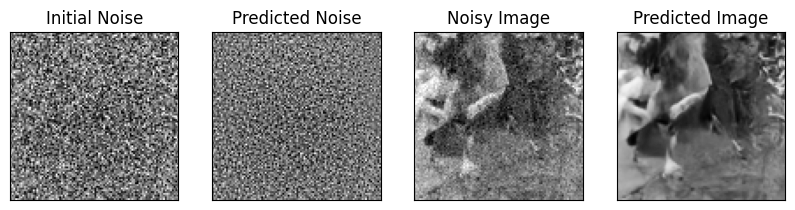

****** Image Gallery ******
Step 1000/1000 | Time Elapsed Last 100 Steps = 28.781482934951782


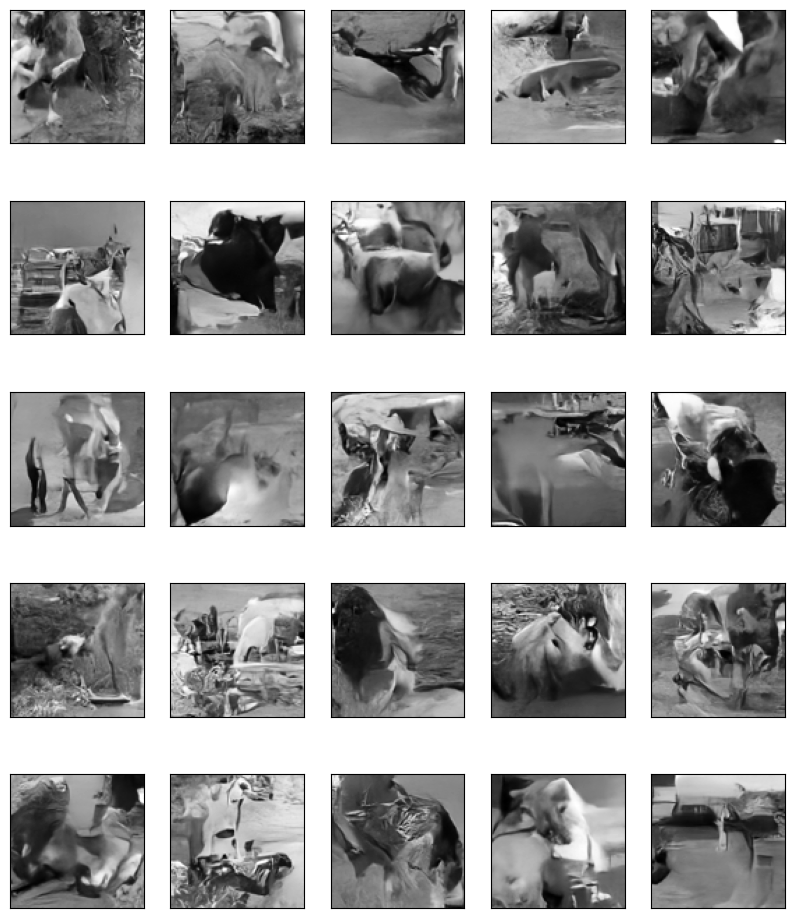

In [46]:
torch.mps.empty_cache()
white_model_images_s00, white_model_sequences_s00 = cd.reverse_diffusion(model=white_model, 
                                         diffusion_steps=1000, 
                                         start_step=0,
                                         print_every=100,
                                         stochasticity=0,
                                         color_channels=1,
                                         num_sequences=4
                                        )

### White Noise Model Image Generation (Stochasticity = 0.1)
Next we modify the reverse diffusion process by feeding in stochasticity at each time step in the form of additional noise. At each reverse time step $t_i$, we predict the noise $\varepsilon_i$. Ordinarly this is fed back into the system as the noise for the next time step. With stochasticity we generate a new noise tensor $\Delta \varepsilon$ and combine it with the predicted noise for the next reverse-time step as follows:
$$
\varepsilon^{(\alpha)}_{i} = \cos\left(\alpha\,\pi/2\right)\  \varepsilon_i + \sin\left(\alpha\,\pi/2\right)\  \Delta \varepsilon\,.
$$
Here $\alpha$ is called the stochasticity parameter, and it is a measure of how much stochastic noise is added to the reverse diffusion process.

For comparison purposes we generate images using the same models with stochasticity parameter equal to $0.1$. 

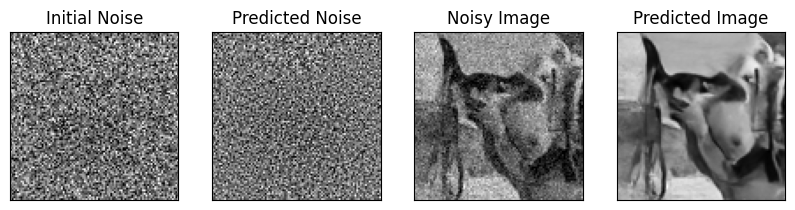

****** Image Gallery ******
Step 1000/1000 | Time Elapsed Last 100 Steps = 28.73239517211914


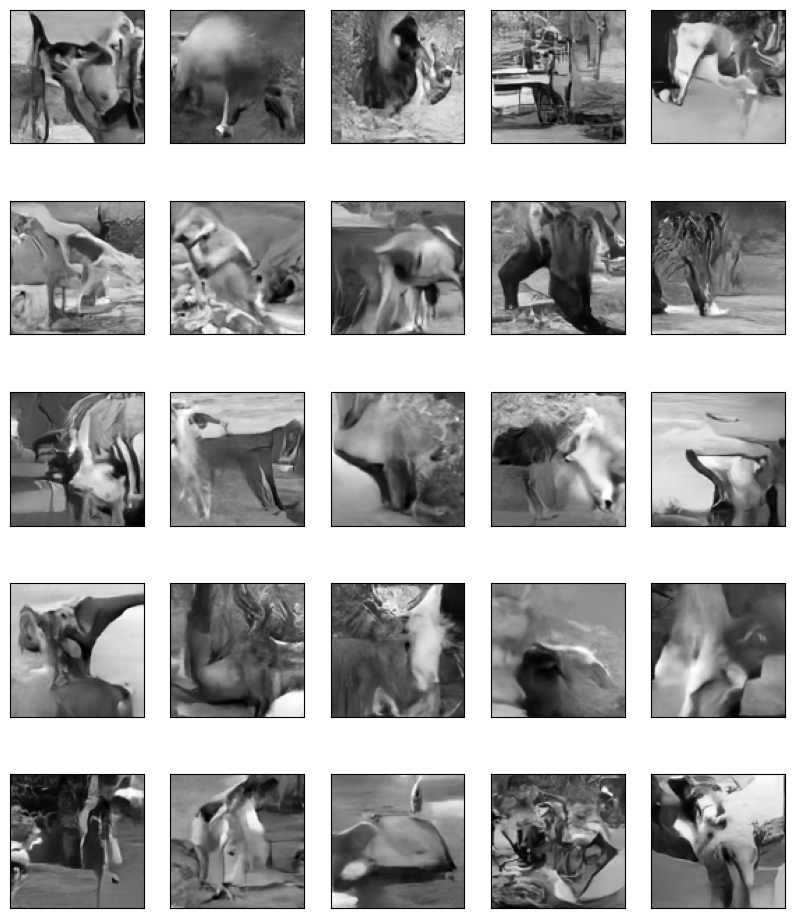

In [47]:
torch.mps.empty_cache()
white_model_images_s01, white_model_sequences_s01 = cd.reverse_diffusion(model=white_model, 
                                         diffusion_steps=1000, 
                                         start_step=0,
                                         print_every=100,
                                         stochasticity=0.1,
                                         color_channels=1,
                                         num_sequences=4
                                        )

### Cloud Diffusion Model Image Generation (No Stochasticity)
We now turn to the Cloud Diffusion Model using unconditional inference with no stochasticity for our first pass. Through trial and error we found that the Cloud Model produces slightly better results when we start at a slightly later timestep (here 50 out of 1000) rather than starting at timestep 0. When we do this, the model effectively attributes more signal to the initial noise tensor and it imbues the image with more structure. 

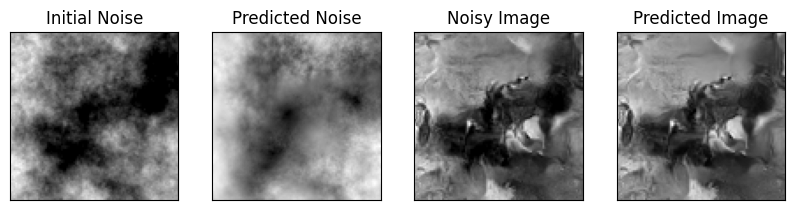

****** Image Gallery ******
Step 1000/1000 | Time Elapsed Last 100 Steps = 29.001482009887695


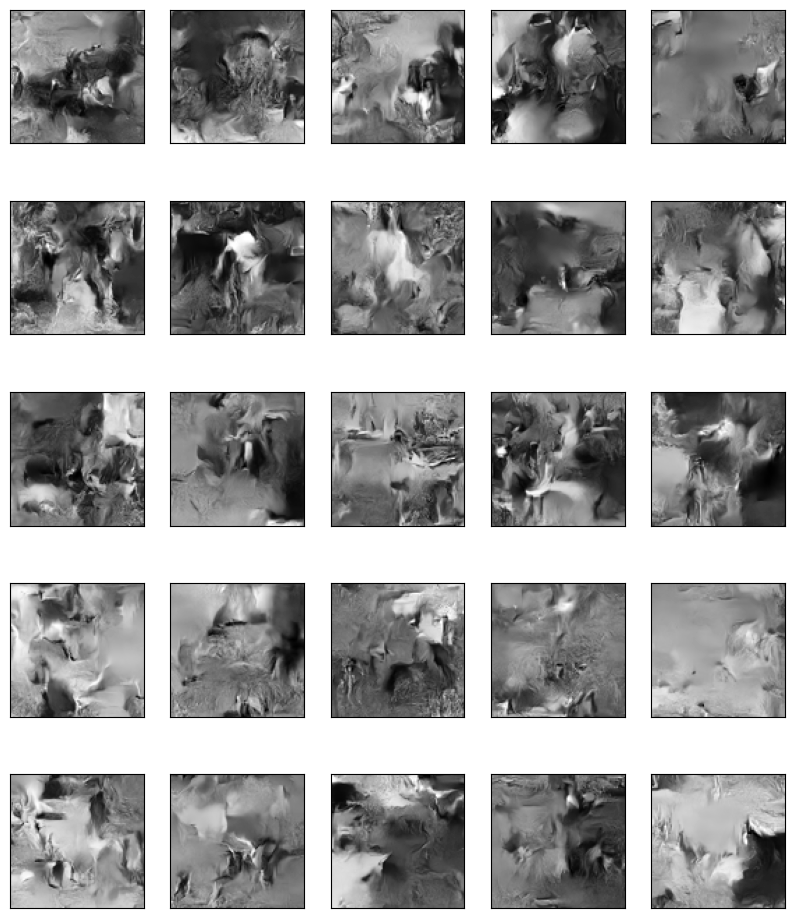

In [7]:
torch.mps.empty_cache()
cloud_model_images_s00, cloud_model_sequences_s00 = cd.reverse_diffusion(model=cloud_model, 
                                         diffusion_steps=1000, 
                                         start_step=50,
                                         print_every=100,
                                         stochasticity=0,
                                         color_channels=1,
                                         num_sequences=4
                                        )

### Cloud Diffusion Model Image Generation (Stochasticity = 0.1)
Next we add stochasticity to the Cloud Diffusion Model...

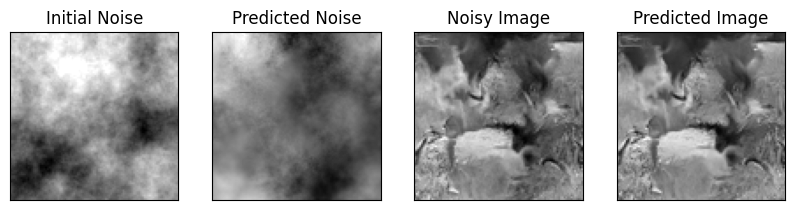

****** Image Gallery ******
Step 1000/1000 | Time Elapsed Last 100 Steps = 30.255733728408813


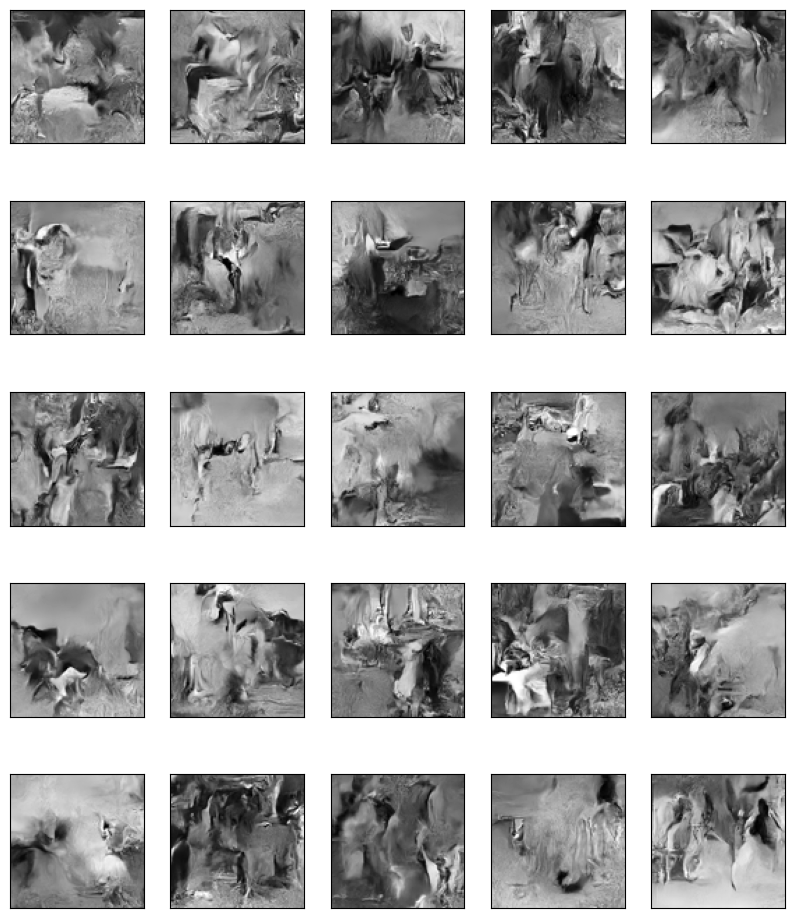

In [20]:
torch.mps.empty_cache()
cloud_model_images_s01, cloud_model_sequences_s01 = cd.reverse_diffusion(model=cloud_model, 
                                         diffusion_steps=1000, 
                                         start_step=0,
                                         print_every=100,
                                         stochasticity=0.1,
                                         color_channels=1,
                                         num_sequences=4
                                        )

## Animating Reverse Diffusion Process
The differences between the white-noise diffusion model and cloud diffusion model are best exemplified with a animated visualization of the reverse diffusion process. Below we show the image generation process for various models through the 1000 reverse diffusion steps. 

### Saving the animations

['animations/white_model_s00_1.mp4',
 'animations/white_model_s00_2.mp4',
 'animations/white_model_s00_3.mp4',
 'animations/white_model_s00_4.mp4']

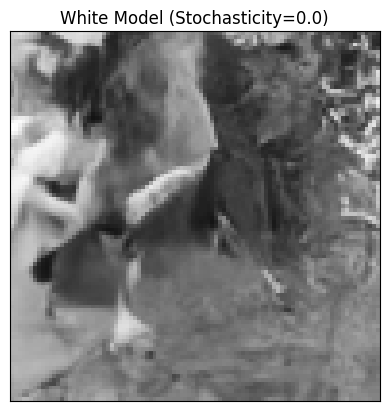

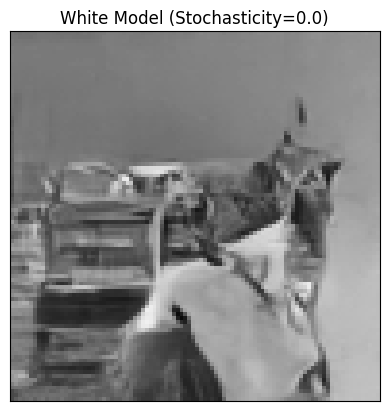

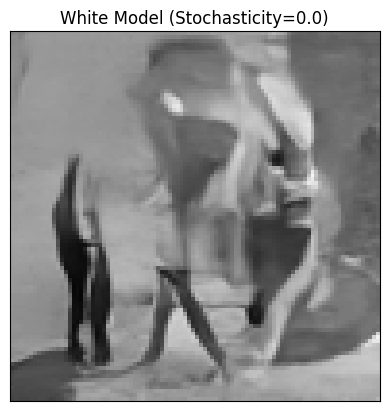

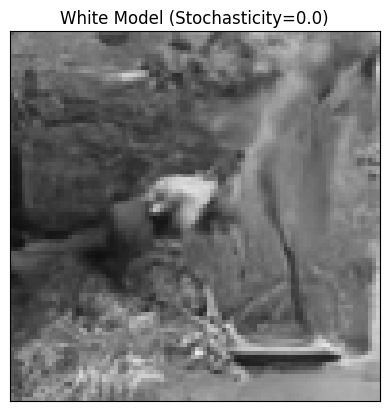

In [63]:
data.save_movies(sequences=white_model_sequences_s00, 
                 model=white_model,
                 title="White Model (Stochasticity=0.0)",
                 filename="white_model_s00")

['animations/white_model_s01_1.mp4',
 'animations/white_model_s01_2.mp4',
 'animations/white_model_s01_3.mp4',
 'animations/white_model_s01_4.mp4']

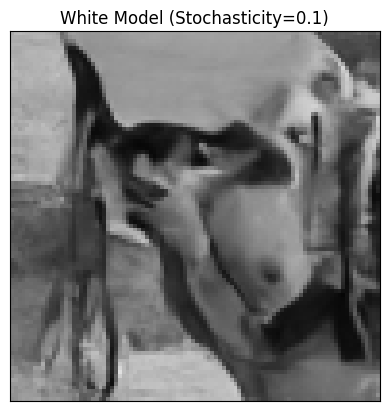

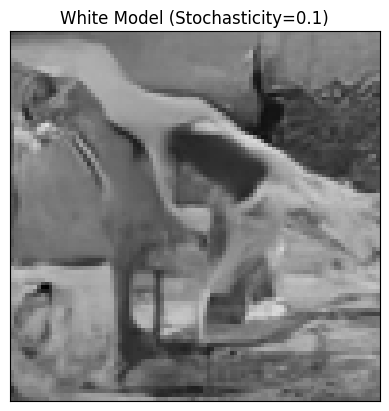

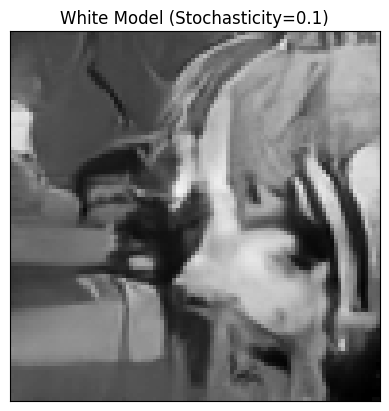

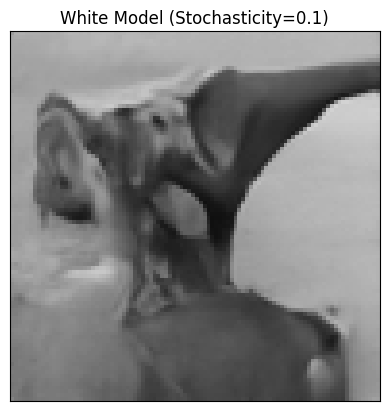

In [64]:
data.save_movies(sequences=white_model_sequences_s01, 
                 model=white_model,
                 title="White Model (Stochasticity=0.1)",
                 filename="white_model_s01")

['animations/cloud_model_s00_1.mp4',
 'animations/cloud_model_s00_2.mp4',
 'animations/cloud_model_s00_3.mp4',
 'animations/cloud_model_s00_4.mp4']

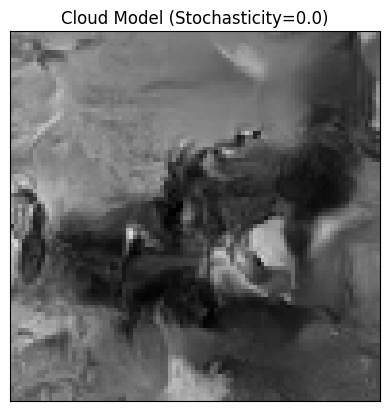

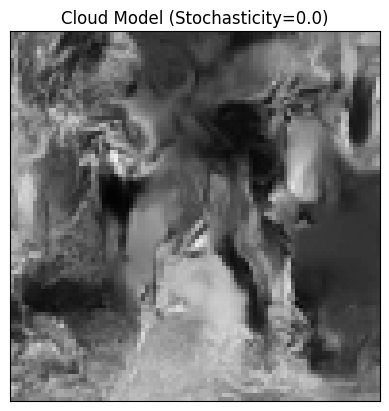

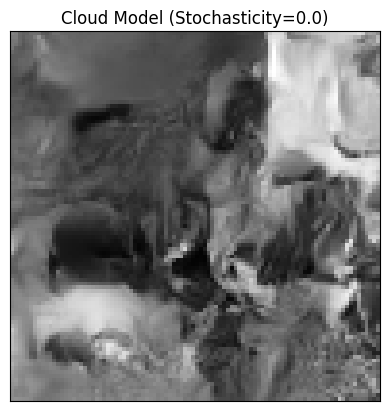

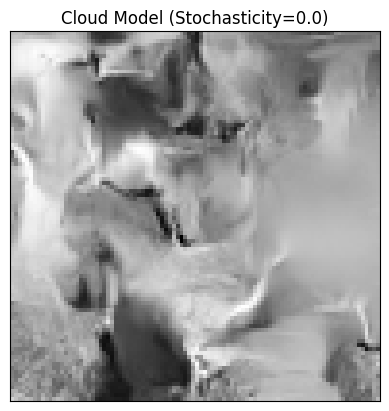

In [18]:
data.save_movies(sequences=cloud_model_sequences_s00, 
                 model=cloud_model,
                 title="Cloud Model (Stochasticity=0.0)",
                 filename="cloud_model_s00")

['animations/cloud_model_s01_1.mp4',
 'animations/cloud_model_s01_2.mp4',
 'animations/cloud_model_s01_3.mp4',
 'animations/cloud_model_s01_4.mp4']

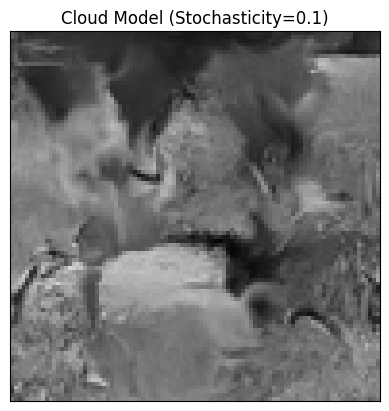

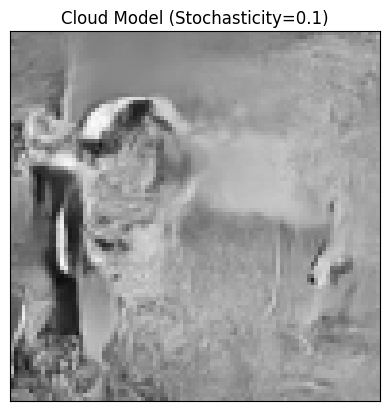

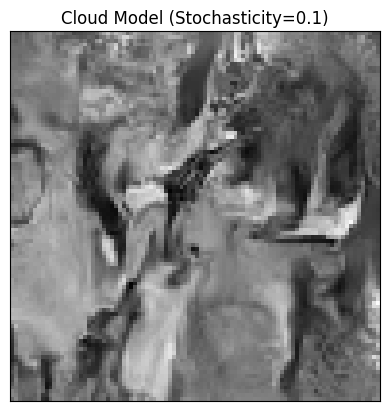

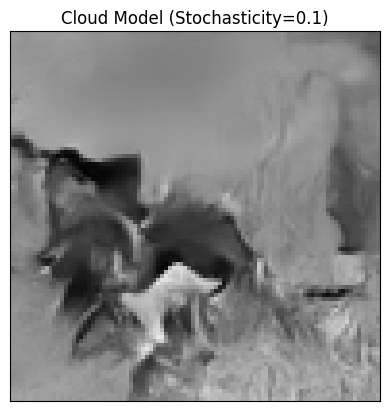

In [21]:
data.save_movies(sequences=cloud_model_sequences_s01, 
                 model=cloud_model,
                 title="Cloud Model (Stochasticity=0.1)",
                 filename="cloud_model_s01")

### Animation: White-Noise Diffusion Model (Stochasticity=0.0)
As expected, the white-noise diffusion models build images from coarse features to fine details...

In [80]:
Video("animations/white_model_s00_1.mp4")

In [81]:
Video("animations/white_model_s00_2.mp4")

### Animation: Cloud Diffusion Model (Stochasticity=0.0)
By contrast, the Cloud Diffusion Model builds images more holistically, slowly improving all wavelengths over the full course of the reverse diffusion process. Note that the appearance of flickering is evidence that the model is functioning as expected. White-diffusion models must fix the overall mean value of the image in the first few frames, while Cloud Diffusion Models continue to adjust the mean value (as well as other coarse features) over all timesteps, giving rise to a flickering effect.

In [12]:
Video("animations/cloud_model_s00_1.mp4")

In [13]:
Video("animations/cloud_model_s00_4.mp4")

### Animation: White-Noise Diffusion Model (Stochasticity=0.1)
Adding stochasticity to the model reveals how random noise injection alters the images over the coarse of the reverse diffusion process. Here we can see the images changing more dramatically as it converges on a final image.

In [74]:
Video("animations/white_model_s01_1.mp4")

In [75]:
Video("animations/white_model_s01_3.mp4")

### Animation: Cloud Diffusion Model (Stochasticity=0.1)
Similarly, adding stochasticity to the Cloud Diffusion Model reveals how random cloud noise injection alters the course of the image generation process. We can see here that even at early timesteps, fine details are created and altered by the random noise injection. Similarly, some coarse features are mutable even at late timesteps. 

In [23]:
Video("animations/cloud_model_s01_1.mp4")

In [22]:
Video("animations/cloud_model_s01_4.mp4")